In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import FastICA
from sklearn.linear_model import Lasso

In [2]:
x_train = pd.read_csv('data/x_train.csv.gz', compression='gzip', header=None, delimiter=';')
y_train = pd.read_csv('data/y_train.csv.gz', compression='gzip', header=None, delimiter=';')
y_train.columns=['target']
y_train=y_train['target']

In [54]:
cross_val_score(KNeighborsClassifier(), x_train, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.40067517313243234

In [234]:
cross_val_score(XGBClassifier(), x_train, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.55919739091001752

In [ ]:
corr = x_train.corr()
corr['sum'] = np.abs(corr).sum()
corr.sort_values(by='sum', inplace=True)
plt.subplots(figsize=(15,15))
sns.heatmap(np.abs(corr.drop(['sum'], axis=1)) >= 0.7, yticklabels=False, xticklabels=False)

In [3]:
corr = (np.abs(x_train.corr()) >=0.7)
corr.shape

(223, 223)

In [111]:
pairs = {}
for i in range(223):
    pairs[i] = []
    for j in range(i, 223):
        if (i != j):
            t = (corr[i] ^ corr[j]).sum()
            if (t <= 5):
                pairs[i].append(j)
    pairs[i] = set(pairs[i])
    if (len(pairs[i])==0):
        del pairs[i]

In [198]:
pairs_list = []
for k in pairs:
    p = [k]
    p.extend(pairs[k])
    pairs_list.append(p)

In [223]:
def find_(i, pairs, walked = []):
    result = []
    for row in pairs:
        if i in row:
            result.extend(row)
            for r in row:
                if r not in walked:
                    result.extend(find_(r, pairs, set(result)))
    return list(set(result))

In [224]:
indexes = list(range(233))
clusters = []
for i in indexes:
    cluster = find_(i, pairs_list)
    if (len(cluster) != 0):
        clusters.append(cluster)
    for c in cluster:
        if (c in indexes):
            indexes.remove(c)

In [233]:
print(len(clusters))
print(np.sum([len(c) for c in clusters]))

17
189


In [226]:
ica = FastICA()
dfs = []
for c in clusters:
    dfs.append(pd.DataFrame(ica.fit_transform(x_train[c]), columns=c, index=x_train.index))

/usr/local/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [235]:
X = pd.concat(dfs, axis=1)

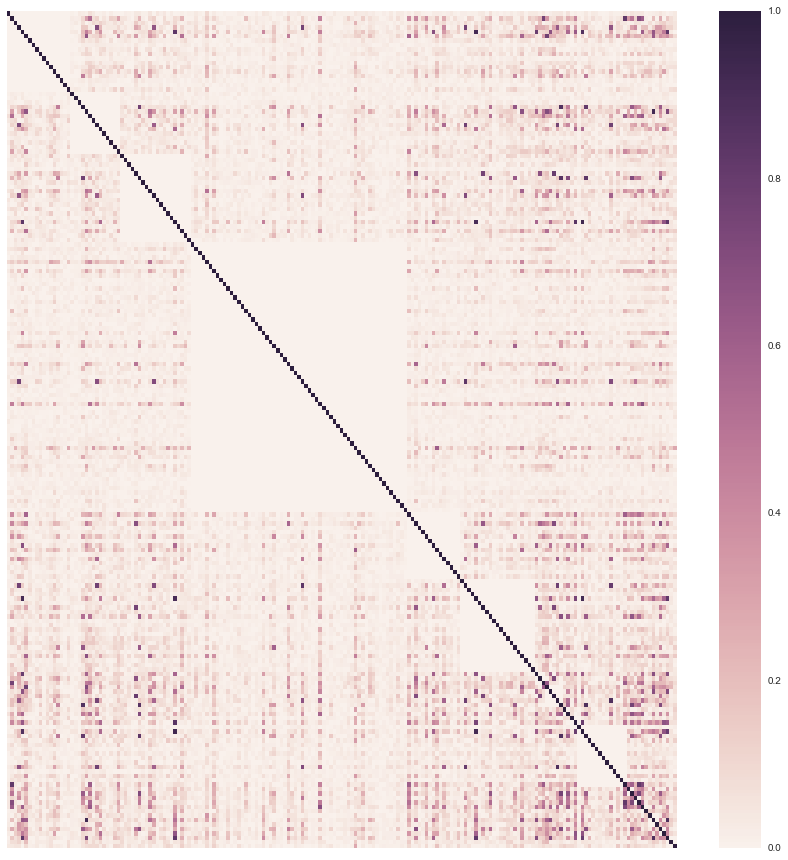

In [238]:
plt.subplots(figsize=(15,15))
sns.heatmap(np.abs(X.corr()), yticklabels=False, xticklabels=False)

In [230]:
cross_val_score(KNeighborsClassifier(), X, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.48292477837865322

In [231]:
cross_val_score(XGBClassifier(), X, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.52966427442673447

In [232]:
cross_val_score(XGBClassifier(), x_train[features], y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.52192662206715279

In [264]:
other_columns = X.columns ^ x_train.columns

In [254]:
cross_val_score(KNeighborsClassifier(), x_train[other_columns], y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.51331539826053785

In [253]:
cross_val_score(XGBClassifier(), x_train[other_columns], y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.52365038183838775

In [267]:
X_all = pd.concat([x_train[other_columns], X], axis=1)

In [269]:
cross_val_score(KNeighborsClassifier(), X_all, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.5127406856168597

In [268]:
cross_val_score(XGBClassifier(), X_all, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()

0.52679685648565933